In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [38]:
import os
os.getcwd()

'/home/ofir/ofir_code/crystoper/notebooks'

In [39]:
def print100(data, n=100):
    for i, v in enumerate(data):
        
        print(v)
        
        if i == n:
            break

In [40]:
data_path = '../data/pdb_data/parsed_data.csv'
df = pd.read_csv(data_path)
df.head()

,pdb_id,pe_index,sequence,poly_type,struct_method,crystal_method,ph,temp,pdbx_details,deposit_date,revision_date
0,5IQ6,1,MDVIGERIKRIKEEHNSTWHYDDENPYKTWAYHGSYEVKATGSASS...,Protein,X-RAY DIFFRACTION,"VAPOR DIFFUSION, SITTING DROP",7.5,293.00,"HEPES pH7.5, PAA (poly acrilic acid) 20%, MgCl...",2016-03-10T00:00:00+0000,2024-05-08T00:00:00+0000
1,5IQB,1,MEYRYDDNATNVKAMKYLIEHYFDNFKVDSIEIIGSGYDSVAYLVN...,Protein,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",7.5,296.00,"80-120mM MgCl2, 8% glycerol, 10% PEG 3350, 100...",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000
2,6IQ4,6,ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTG...,DNA,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",6.0,291.15,"manganese chloride, potassium chloride, potass...",2018-11-06T00:00:00+0000,2024-03-27T00:00:00+0000
3,4IQJ,4,MGSKLKFAHLHQHTQFSLLDGAAKLQDLLKWVKETTPEDPALAMTD...,Protein,X-RAY DIFFRACTION,"VAPOR DIFFUSION, SITTING DROP",8.8,298.00,"0.1 M TRIS pH 8.8, 18% (w/v) polyethylene glyc...",2013-01-11T00:00:00+0000,2023-09-20T00:00:00+0000
4,4IQW,1,HMSPSPVPGSQNVPAPAVKKISQYACQRRTTLNNYNQLFTDALDIL...,Protein,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",6.0,293.00,"20% PEG4000, 200 mM sodium formate, 100 mM MES...",2013-01-13T00:00:00+0000,2023-09-20T00:00:00+0000


# features in the data in the data
* pdb_id - id of the entry 
* pe_index - id of the polymer entity (a sub-unit in an entry)
* sequence - the sequence of a polymer entity
* poly_type - type of polymeric entity
* struct_method - method used to detrmine the crystal structure 
* crystal_method - method used to create the structure
* ph - pH in the buffer durring crystallization
* temp - temperature (in K) in the buffer durring crystallization
* pdbx_details - free text describing the crystallization process and the buffer reagents.
* deposit_date - date of structure deposit in the PDB.
* revision_date - date of last revision of the entry in the PDB.



# PDB structure, "entry" and "polymer entity"
A single PDB structure (AKA entry) can have multiple separate polymeric subunits (AKA polymer entities).

Poly entities of the same PDB entry will have exactly same info in all features except 'pe_index', 'sequence' and 'poly_type' 

this is because all entities of a single entry were crystalize together in the same assay.

In [45]:
#we will get a df of entries alone by leaving only entry-derived columns and dropping duplicates
cols = list(df.columns)
cols = [col for col in cols if col not in ('pe_index', 'sequence', 'poly_type')]
df_entries = df[cols].drop_duplicates()

#we will name the full data of all chains df_pe for 'polymeric entities'
df_pe = df.copy()

df_entries


,pdb_id,struct_method,crystal_method,ph,temp,pdbx_details,deposit_date,revision_date
0,5IQ6,X-RAY DIFFRACTION,"VAPOR DIFFUSION, SITTING DROP",7.5,293.00,"HEPES pH7.5, PAA (poly acrilic acid) 20%, MgCl...",2016-03-10T00:00:00+0000,2024-05-08T00:00:00+0000
1,5IQB,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",7.5,296.00,"80-120mM MgCl2, 8% glycerol, 10% PEG 3350, 100...",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000
2,6IQ4,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",6.0,291.15,"manganese chloride, potassium chloride, potass...",2018-11-06T00:00:00+0000,2024-03-27T00:00:00+0000
3,4IQJ,X-RAY DIFFRACTION,"VAPOR DIFFUSION, SITTING DROP",8.8,298.00,"0.1 M TRIS pH 8.8, 18% (w/v) polyethylene glyc...",2013-01-11T00:00:00+0000,2023-09-20T00:00:00+0000
4,4IQW,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",6.0,293.00,"20% PEG4000, 200 mM sodium formate, 100 mM MES...",2013-01-13T00:00:00+0000,2023-09-20T00:00:00+0000
...,...,...,...,...,...,...,...,...
291874,3L9V,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",7.0,293.00,"1.45M sodium malonate, 0.5% (w/v) Jeffamine ED...",2010-01-05T00:00:00+0000,2017-11-01T00:00:00+0000
291875,7L9Q,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",8.6,298.00,"23% PEG3350, 100 mM Tris-HCl, pH 8.6, 200 mM m...",2021-01-04T00:00:00+0000,2023-10-18T00:00:00+0000
291876,4L9D,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",5.5,291.00,"1.2 M sodium citrate and 20% (w/v) PEG 8K, pH ...",2013-06-18T00:00:00+0000,2024-02-28T00:00:00+0000
291877,1L96,X-RAY DIFFRACTION,NaN,NaN,NaN,NaN,1992-02-11T00:00:00+0000,2024-02-14T00:00:00+0000


In [46]:
print(f"In total the data contains {df_entries.shape[0]} PDB structures (entries) that are made of {df_pe.shape[0]} polymer entities")

In total the data contains 188770 PDB structures (entries) that are made of 291880 polymer entities


In [47]:
# The data was filter for X-RAY only when fetching. yet - we want to validate it
print(df_entries.groupby('struct_method').size())

struct_method
ELECTRON CRYSTALLOGRAPHY         3
ELECTRON MICROSCOPY            345
FIBER DIFFRACTION               30
NEUTRON DIFFRACTION             40
POWDER DIFFRACTION              21
SOLID-STATE NMR                 13
SOLUTION NMR                   205
SOLUTION SCATTERING             21
X-RAY DIFFRACTION           188092
dtype: int64


In [48]:
#let filter out all the non X-ray data
df_pe = df_pe.query('struct_method == "X-RAY DIFFRACTION"')
df_entries = df_entries.query('struct_method == "X-RAY DIFFRACTION"')


In [49]:
#while most crystallization data is for Proteins, some structures contain also DNA and RNA. For the sake of this model we prefer to leave does out.
#lets see their fraction in the data
df_pe.groupby('poly_type').size()

poly_type
DNA           15101
NA-hybrid       218
Other             6
Protein      268067
RNA            6529
dtype: int64

In [50]:
mixed_ids = set(df_pe.query('poly_type != "Protein"').pdb_id)
proteins_only_ids = set([id for id in df_pe.pdb_id if id not in mixed_ids])
print(f'out of {len(df_entries)} structures, {len(proteins_only_ids)} contains proteins only')



out of 188092 structures, 176361 contains proteins only


In [51]:
#for the sake of our model will use proteins-only structures. So - we will filter-out mixed strctures
df_pe = df_pe[df_pe.pdb_id.isin(proteins_only_ids)]
df_entries = df_entries[df_entries.pdb_id.isin(proteins_only_ids)]

0
1     142352
2      23783
3       6875
4       1791
5        675
6        146
7         60
8         35
9         10
10        40
11        33
12        24
13        85
14       263
15        65
16        16
17         3
18         6
19        13
20        83
22         1
48         2
dtype: int64

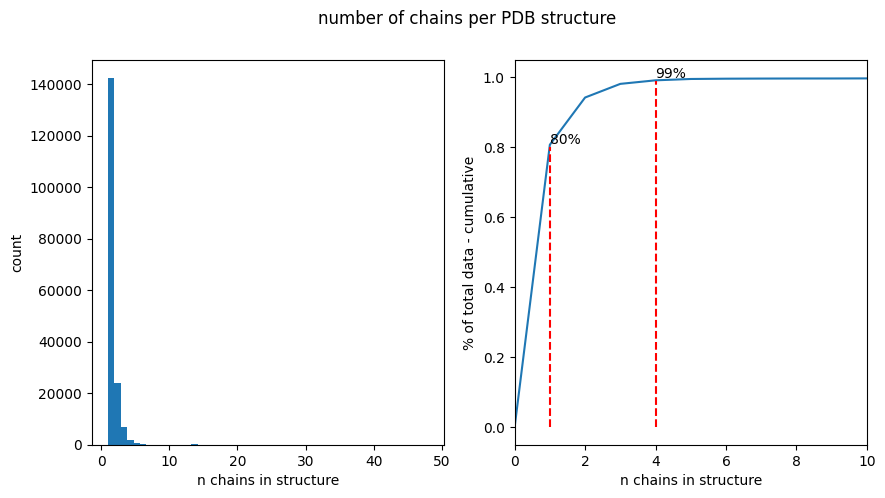

In [53]:
#lets explore how many separate chains per structure - meaning how many polymer entities per pdb_id
n_chains = df_pe.groupby('pdb_id').size()

fig, axes = plt.subplots(1,2, figsize=[10,5])

ax = axes[0]
ax.hist(n_chains, bins=50);
ax.set_xlabel('n chains in structure')
ax.set_ylabel('count')

#calculate cumsum the histogram data for counting number of pdb_id with x chains
cumsum = n_chains.to_frame().reset_index().groupby(0).size().cumsum()
cumsum = pd.concat([pd.Series((0)), cumsum]) #add dummy zero
cumsum /= cumsum.iloc[-1]

ax = axes[1]
 
ax.plot(cumsum)
ax.set_xlabel('n chains in structure')
ax.set_ylabel('% of total data - cumulative')

# ax.hlines([0.8, 0.99], 0, 50, color='red', linestyles='--')
ax.vlines([1, 4], [0, 0], [0.8, 0.99], color='red', linestyles='--')
ax.text(1, 0.81, '80%')
ax.text(4 ,1, '99%')
ax.set_xlim([0,10])

fig.suptitle('number of chains per PDB structure')

n_chains.to_frame().reset_index().groupby(0).size()

As seen in the above figure, 80% have single chain, and 99% has 5 chains or less.

We will start by training a model for the simpler task of predicting conditions for structures with a single chain only.

Later on a model that take up to 5 polymeric chains.

In [54]:
#filter for single chains
s = df_pe.groupby('pdb_id').size()
singles_ids = set(s[s == 1].index)
df_pe = df_pe[df_pe.pdb_id.isin(singles_ids)]
df_entries = df_entries[df_entries.pdb_id.isin(singles_ids)]





In [55]:
#as we depend on the 'pdbx_details' feature as our label, lets remove instances the lack this feature
print(f'Out of {len(df_entries)} entries in current data, {len(df_entries.query("pdbx_details.isna()"))} lack pdbx details')


Out of 142352 entries in current data, 5866 lack pdbx details


In [56]:
#lets filter does out
df_entries = df_entries.query('pdbx_details.notna()')
df_pe = df_pe.query('pdbx_details.notna()')

# pH and Temp
Lets overview the pH and Temp in the data.

As a POC, we want to train a model that predicts pH and Temp alone

Lets see how these features look like

We will start by looking at Nan values and filling them out

In [57]:
n = len(df_entries)
ph_miss = len(df_entries[df_entries.ph.isna()])
print(f'Out of {n} entries, {ph_miss} are missing pH ({100*ph_miss/n:.2f}%)')

Out of 136486 entries, 28732 are missing pH (21.05%)


In [58]:
#lets fill the missing ph values by extracting the from the verbal description

def parse_ph_from_string(s):
    s = s.lower()
    matches =  re.findall(r'ph\s*=*\s*?\d+(?:\.\d+)?', s)
    
    if len(matches) >=1 :
        v = matches[0]
        v = v.replace('ph', '').replace('=', '').replace(":", "").strip()
        v = float(v)
        if not 0.1 < v < 14:
            v = np.nan
            
        return v
        
    else:
        return np.nan

m = df_entries.ph.isna()
parsed_ph = df_entries.loc[m, 'pdbx_details'].apply(parse_ph_from_string)

df_entries.loc[m, 'ph'] = parsed_ph

n = parsed_ph.notna().sum()
n_missing_ph = df_entries.ph.isna().sum()

print(f'Parsed ph for {n} entries!')
print(f'for {n_missing_ph} pH could not be parsed ({100*(n_missing_ph/len(df_entries)):.2}%)') 


Parsed ph for 17550 entries!
for 11182 pH could not be parsed (8.2%)


In [59]:
#looking at the records for which pH could not be parsed, we see indeed that this data is scarse from the 'pdbx_details' feature
print100(df_entries.query('ph.isna()').pdbx_details, n=20)

100 mM imidazole, 35% MPD, 200 mM magnesium chloride
100 mM imidazole, 15%(v/v) reagent alcohol, 200 mM magnesium chloride
100mM sodium citrate, 30% PEG 400, VAPOR DIFFUSION, HANGING DROP, temperature 293K
PEG3350, sodium thyocinate
VAPOR DIFFUSION, HANGING DROP, temperature 297K
100 mM imidazole, 15%(v/v) reagent alcohol, 200 mM magnesium chloride, 2.0 mM nickel chloride
0.15 M KBr, 30 % w/v PEG 2000 MME
The reservoir contained 0.1 M magnesium formate dihydrate, 15% w/v PEG 3350 and 0.1 M Hepes.  The enzyme stock solution included 3 mg/mL ALDH7A1, 200 micromolar 4-diethyaminobenzaldehyde and 5 mM NAD+.
KCl, Tris, PEG3350
0.2M Magnesium acetate  20% PEG 3350, VAPOR DIFFUSION, HANGING DROP, temperature 295K
PEG 3350, Sodium formate
VAPOR DIFFUSION, HANGING DROP
Reservoir contained 0.2 M MgCl2, 25% (w/v) PEG3350, 0.1 M Tris at pH of 8.2, 1% DMSO, 200 micromolar 4-diethylaminobenzaldehyde.  Protein stock solution contained 3 mg/mL ALDH7A1 and 200 micromolar DEAB.
4.0M NA FORMATE WITH 20% 

In [60]:
#we wil fill in some missing temperature values
def parse_temp_from_string(s):
    s = s.lower()
    matches =  re.findall(r'temperature \d\d\dK?', s)
    
    if len(matches) > 0:
        return int(matches[0].split()[-1])
    else:
        return np.nan


m = df_entries.temp.isna()
parsed_temp = df_entries.loc[m, 'pdbx_details'].apply(parse_temp_from_string)
df_entries.loc[m, 'temp'] = parsed_temp

n = parsed_temp.notna().sum()
n_missing_temp = df_entries.temp.isna().sum()

print(f'Parsed temp for {n} entries!')
print(f'for {n_missing_temp} out of {len(df_entries)} we could not extract temp ({100*n_missing_temp/len(df_entries):.2}%)') 



Parsed temp for 281 entries!
for 14584 out of 136486 we could not extract temp (1.1e+01%)


In [61]:
#looking at some of the records with missing tempratue we see inddeed that the info is missing from the 'pdbx_details' feature
print100(df_entries.query('temp.isna()').pdbx_details, 20)

DIALYSIS AGAINST PHOSPHATE BUFFER 50 MM PH 6, MPD 30%
PROTEIN: 5 MICROL OF 6 MG/ML GGAPDH IN 25 MM TRIS HCL PH 7.8, 0.6M AMMONIUM SULPHATE, 2MM NAD, 1MM DITHIOTHREITOL 1MM NA AZIDE, 1 MM EDTA. PRECIPITANT: 5 MICROL OF 52% SATURATED AMMONIUM SULPHATE, 0.2M N,N-BIS-(2-HYDROXYETHYL)-2-AMINOETHANE SULFONIC ACID PH 6.5, 1MM DITHIOTHREITOL, 1MM NA AZIDE, 1MM EDTA, 20MM 3-PHOSPHOGLYCERATE. RESERVOIR: 1 ML
DIALYSIS AGAINST PHOSPHATE BUFFER 50 MM PH 6, MPD 30%
VAPOR DIFFUSION, HANGING DROP
INITIAL PROTEIN DROPLET: 16 MG/ML PROTEIN, 10 MM NADH, 20 M RESERVOIR: 1.6 M AMMONIUM SULPHATE, 20% (V/V) GLYCEROL, 80 M DROPLET: EQUAL VOLUMES OF INITIAL PROTEIN DROPLET AND RESERVOIR WERE MIXED., pH 4.0
1.6M AS, 0.1M HEPES, PEG 400, DMSO, PH 7
pH 7.5
4.0M NA FORMATE WITH 20% GLYCEROL AS A CRYOPROTECTANT
0.2 M AMMONIUM SULFATE, 0.1 M SODIUM CACODYLATE PH 6.5 AND 30 % PEG 8000 AND GAMMA-BUTYROLACTONE
HANGING DROP, 2 MICROLITER PROTEIN AND 2 MICROLITER PRECIPITANT SOLUTION. PROTEIN SOLUTION. 50 MG/ML, 20 MM IM

         count        mean       std    min    25%    50%    75%    max
ph    125304.0    6.775695  1.299657    0.1    6.0    7.0    7.5   12.0
temp  121902.0  290.969985  8.222462  100.0  290.0  293.0  295.0  323.0


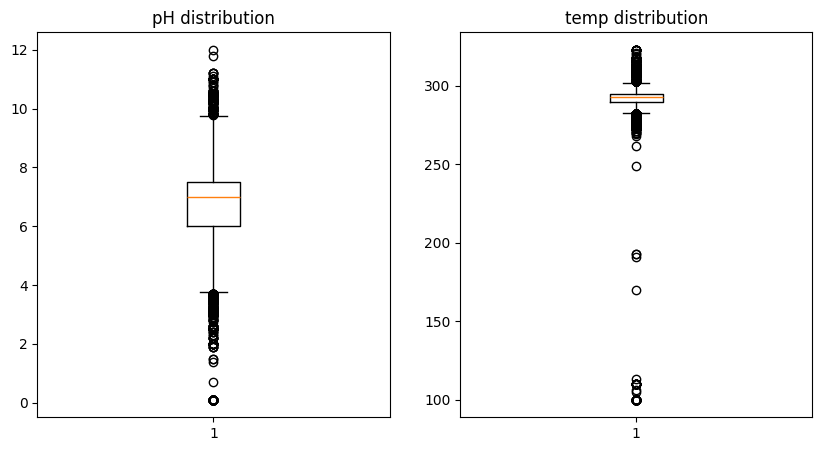

In [62]:
fig,axes = plt.subplots(1, 2, figsize=[10,5])

y = df_entries[df_entries.ph.notna()].ph
ax = axes[0]
ax.boxplot(y);
ax.set_title('pH distribution')

y = df_entries[df_entries.temp.notna()].temp
ax = axes[1]
ax.boxplot(y);
ax.set_title('temp distribution')


print(df_entries[['ph', 'temp']].describe().T)

As expected, most data is centered around pH 6-7.5 (~ physiological pH ) and temp 290-296 K (slightly bellow room temp).

Temp < 273K (0 C) is unlikely and most likely relates to the temprature in which the crystals were X-RAY projected for solving the structure (which is is not related to he scope of this research - which is to find the a model that predicts the conditions for crystals formation)

(An example for X-RAY conditions parsed in PDB as crystals conditions can be found in 8A0Y, Sivaraman KK, er al 2012)

# crystal method
'Crystal method' feature is physical method used for the crystallization process.
The most common method is 'vapor diffusion'. meaning: the protein is 'sits' in a drop and another drop of protein-free buffer ('reservoir) is next to it. The protein drop can be hanging on the top of the reservoir well (aka 'hanging') or placed on some supportive surface above the reservoir (aka 'sitting'). in both settings, there is a slow vaporizing of water from the protein droplet to the reservoir.


In [63]:
#lets see whats in 'crystal_method


In [64]:
df_entries.groupby('crystal_method').size().sort_values(ascending=False).head(50)

crystal_method
VAPOR DIFFUSION, HANGING DROP              59429
VAPOR DIFFUSION, SITTING DROP              46722
VAPOR DIFFUSION                             6894
MICROBATCH                                  1665
EVAPORATION                                 1546
BATCH MODE                                   972
LIPIDIC CUBIC PHASE                          889
SMALL TUBES                                  326
hanging drop                                 314
MICRODIALYSIS                                255
LIQUID DIFFUSION                             248
VAPOR DIFFUSION,SITTING DROP,NANODROP        182
COUNTER-DIFFUSION                            131
batch                                        105
microbatch under oil                         101
VAPOR DIFFUSION, SITTING DROP, NANODROP       92
IN CELL                                       69
BATCH                                         62
SLOW COOLING                                  58
MICROBATCH UNDER OIL                          57
sitti

In [65]:
#we will make 'crystal_method' values more uniform. we will the most common ones:['EVAPORATION', 'IN-CELL', 'SMALL-TUBES', 'BATCH', 'SEEDING', 'LCP', 'DIALYSIS', 'HANGING-DROP', 'SITTING-DROP',  'UNKNOWN']                        
#missing values will be assumed to be 'HANGING DROP' as this is the most common method

NEW_METHODS = ['EVAPORATION', 'IN-CELL', 'SMALL-TUBES', 'BATCH', 'SEEDING', 'LCP', 'DIALYSIS', 'HANGING-DROP', 'SITTING-DROP',  'UNKNOWN']

def process_crystal_method(v):
    
    if not v:
        v = ''
    
    v = v.lower()
    
    if 'evaporation' in v:
        return 'EVAPORATION'
    
    if 'cell' in v:
        return 'IN-CELL'
    
    if 'tubes' in v:
        return 'SMALL-TUBES'
    
    if 'batch' in v:
        return 'BATCH'
    
    if 'seed' in v:
        return 'SEEDING'
    
    if 'cubic' or 'lcp' in v:
        return 'LCP'
    
    if 'dial' in v:
        return 'DIALYSIS'
    
    if 'hang' in v:
        return 'HANGING-DROP'
    
    if 'sit' in v:
        return 'SITTING-DROP'
    
    #if vapor exists but now 'sitting' we assume sitting drop
    if 'vapor' in v:
        return 'SITTING-DROP'
    
    else:
        return np.nan

In [66]:
#we will process 
df_entries['crystal_method'] = df_entries['crystal_method'].fillna('').apply(process_crystal_method)
df_pe['crystal_method'] = df_pe['crystal_method'].fillna('').apply(process_crystal_method)

n = df_entries.crystal_method.isna().sum()
print(f'There are {n} missing "crystal method" values ({100*n/len(df_entries):.2}%)')

There are 0 missing "crystal method" values (0.0%)


In [67]:
df_entries.isna().sum()

pdb_id                0
struct_method         0
crystal_method        0
ph                11182
temp              14584
pdbx_details          0
deposit_date          0
revision_date         0
dtype: int64

In [68]:
#lastly, we will check if there are any missing values
df = df_entries.isna().sum().to_frame()
df.columns = ['missing']
df['total'] = len(df_entries)
df['pct_missing'] = 100 * df.missing / df.total
df

,missing,total,pct_missing
pdb_id,0,136486,0.000000
struct_method,0,136486,0.000000
crystal_method,0,136486,0.000000
ph,11182,136486,8.192782
temp,14584,136486,10.685345
pdbx_details,0,136486,0.000000
deposit_date,0,136486,0.000000
revision_date,0,136486,0.000000


So the only missing values are ph (%8) and temp (10%).
We will filter those out for the sake of the simpler models that predicts ph or temp (respectively) for the simpler models that predicts those directly.

# Filtering
For now we will not use extra filtering. But for the models to be trained, we will filter based on the following logic:

* For the sake of simple models that predicts pH, temperature or crystal-method directly - we will remove instances with missing values.
* we will filter temp < 273K because they most likely does not represent crystal formation conditions.
* The final model will be trained directly on the pdbx_detail labels - so we will only filter missing lables.


# Sequences Embedding
As input for our models we will use pooling of the hidden layers from ESM2. ESM (Evolutionary Scale Modeling) is a transformer-based proteins Languge Models developed by META that exhibits state-of-the-art performance for various protein-related tasks (https://github.com/facebookresearch/esm). There for - its embedded vectors capture eminent properties of the protein sequence, and hopefully will allow proper crystallization conditions predictor. 

We will reload the sequences data as filtered by crystoper.

In [3]:
#reload filtered data
df = pd.read_csv('../data/pdb_data/processed_data.csv')
df.head()

,pdb_id,pe_index,sequence,poly_type,struct_method,crystal_method,ph,temp,pdbx_details,deposit_date,revision_date
0,5IQ6,1,MDVIGERIKRIKEEHNSTWHYDDENPYKTWAYHGSYEVKATGSASS...,Protein,X-RAY DIFFRACTION,LCP,7.5,293.0,"HEPES pH7.5, PAA (poly acrilic acid) 20%, MgCl...",2016-03-10T00:00:00+0000,2024-05-08T00:00:00+0000
1,5IQB,1,MEYRYDDNATNVKAMKYLIEHYFDNFKVDSIEIIGSGYDSVAYLVN...,Protein,X-RAY DIFFRACTION,LCP,7.5,296.0,"80-120mM MgCl2, 8% glycerol, 10% PEG 3350, 100...",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000
2,5IQ7,3,RRRNEQELLELDKWASLWNWFDITNWLWYIRRRR,Protein,X-RAY DIFFRACTION,LCP,7.5,293.0,"40% PEG400, 0.1M NaCitrate, 0.1M Tris-HCl, 7.5",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000
3,5IQ7,2,YELTQETGVSVALGRTVTITCRGDSLRSHYASWYQKKPGQAPILLF...,Protein,X-RAY DIFFRACTION,LCP,7.5,293.0,"40% PEG400, 0.1M NaCitrate, 0.1M Tris-HCl, 7.5",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000
4,5IQ7,1,EVQLVESGGGLVKPGGSLRLSCSASGFDFDNAWMTWVRQPPGKGLE...,Protein,X-RAY DIFFRACTION,LCP,7.5,293.0,"40% PEG400, 0.1M NaCitrate, 0.1M Tris-HCl, 7.5",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000


In [4]:
#load sequence vectors
vec_path = '../vectors/sequences/esm2.npy'
vectors = pd.DataFrame(np.load(vec_path))
vectors

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0.080090,-0.054516,-0.009489,0.019288,-0.091814,-0.041800,-0.006620,-0.111776,0.056863,-0.005299,...,0.007958,-0.060773,-0.045878,-0.016804,0.029044,0.085492,0.060096,-0.040851,-0.020203,0.082755
1,0.211253,-0.035145,0.082780,0.109291,-0.110988,-0.016267,-0.134059,-0.238016,0.072340,0.121512,...,0.173475,-0.235556,-0.008016,0.085362,-0.146759,-0.017949,0.116581,-0.376761,0.002806,-0.110480
2,1.024906,-1.838284,2.429650,0.900196,-0.121465,0.088790,-0.067466,-0.100629,-1.903184,0.587946,...,-1.940980,-2.744739,-1.203241,2.640132,0.501258,0.510888,1.535608,-3.492898,3.542368,-2.029043
3,0.124748,-0.243674,0.038784,0.609947,-0.465015,0.028226,0.372770,-0.197219,-0.029284,0.702349,...,-0.254816,-0.005715,-0.258924,-0.093769,-0.029758,-0.132425,0.265917,-0.375190,-0.030233,-0.227631
4,-0.022996,-0.302802,-0.025733,0.780110,-0.622005,0.134997,0.287760,-0.095160,0.002874,0.584445,...,-0.245421,-0.047219,-0.339246,-0.029138,0.034997,-0.328667,0.178830,-0.396633,0.147787,-0.146470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222361,-0.059006,0.003493,-0.058620,0.021242,-0.085301,-0.027818,-0.056070,-0.093941,-0.090080,0.032034,...,0.016152,-0.010662,-0.041672,0.013945,-0.124881,0.036683,-0.003700,-0.159539,0.013903,0.051385
222362,0.018114,-0.175250,-0.031602,0.290197,-0.200760,0.011112,0.085327,-0.145246,-0.036334,0.343677,...,-0.110494,-0.102175,-0.184846,-0.059598,-0.024721,-0.174346,0.175850,-0.257301,0.093734,-0.009342
222363,0.029771,-0.179163,0.059889,0.039374,-0.137923,-0.039572,0.041683,-0.265551,0.140509,0.074680,...,-0.011974,-0.202386,0.087949,0.050495,0.009344,0.113736,0.149147,-0.331329,0.029073,0.016653
222364,0.019018,-0.107523,0.051970,-0.062569,-0.042680,-0.018678,0.102584,-0.101200,0.003385,0.049444,...,-0.048698,-0.051056,-0.070519,-0.056929,-0.087801,0.033088,0.100686,-0.172439,0.087534,-0.006132


In [5]:
#lets see how this vectors look like
sns.heatmap(vectors)

: 

In [36]:
df_entries

,pdb_id,struct_method,crystal_method,ph,temp,pdbx_details,deposit_date,revision_date
0,5IQ6,X-RAY DIFFRACTION,LCP,7.5,293.0,"HEPES pH7.5, PAA (poly acrilic acid) 20%, MgCl...",2016-03-10T00:00:00+0000,2024-05-08T00:00:00+0000
1,5IQB,X-RAY DIFFRACTION,LCP,7.5,296.0,"80-120mM MgCl2, 8% glycerol, 10% PEG 3350, 100...",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000
8,4IQC,X-RAY DIFFRACTION,LCP,7.5,298.0,"62% ammonium sulfate, 0.1 M HEPES, pH 7.5, 4% ...",2013-01-11T00:00:00+0000,2023-09-20T00:00:00+0000
9,4IQG,X-RAY DIFFRACTION,LCP,7.2,289.0,"0.15 M sodium formate, 20% PEG 3350, pH 7.2, V...",2013-01-11T00:00:00+0000,2022-04-13T00:00:00+0000
10,8IQ0,X-RAY DIFFRACTION,LCP,5.5,291.0,"25%PEG4000, 150mM ammonium sulfate and 100 mM MES",2023-03-15T00:00:00+0000,2023-09-06T00:00:00+0000
...,...,...,...,...,...,...,...,...
291867,1L9E,X-RAY DIFFRACTION,LCP,7.0,295.0,"phosphate, imidazole, pH 7.0, VAPOR DIFFUSION,...",2002-03-22T00:00:00+0000,2023-08-16T00:00:00+0000
291868,6L98,X-RAY DIFFRACTION,LCP,6.5,283.0,100 mM MES\n15% glycerol\n15% PEG6000,2019-11-08T00:00:00+0000,2023-11-22T00:00:00+0000
291874,3L9V,X-RAY DIFFRACTION,LCP,7.0,293.0,"1.45M sodium malonate, 0.5% (w/v) Jeffamine ED...",2010-01-05T00:00:00+0000,2017-11-01T00:00:00+0000
291875,7L9Q,X-RAY DIFFRACTION,LCP,8.6,298.0,"23% PEG3350, 100 mM Tris-HCl, pH 8.6, 200 mM m...",2021-01-04T00:00:00+0000,2023-10-18T00:00:00+0000
